<a href="https://colab.research.google.com/github/Vulpeszgg/study_NN_NEVOD-/blob/main/net1(EncoderDecoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1 loss: 0.0736270096309692, recall: 0.03582328013536111, precision: nan, IoU: 0.026500719695169234
Epoch 2 loss: 0.007551198744728605, recall: 0.49500406516071793, precision: 0.8046057728406425, IoU: 0.43620127293272554
Epoch 3 loss: 0.003779238071423198, recall: 0.7749704211671776, precision: 0.836422437819365, IoU: 0.6721660125756932
Epoch 4 loss: 0.002614914817152388, recall: 0.8399918196357299, precision: 0.8579248451740942, IoU: 0.7369484207897543
Epoch 5 loss: 0.002034652202986355, recall: 0.8746754507595134, precision: 0.8763681856271263, IoU: 0.7785647177250585
Epoch 6 loss: 0.0017072577500023888, recall: 0.8960565328598022, precision: 0.8882466173060587, IoU: 0.8054574048407724
Epoch 7 loss: 0.0014658055989567851, recall: 0.9122755391018413, precision: 0.8968454861195287, IoU: 0.8259185374340164
Epoch 8 loss: 0.0013268034250767048, recall: 0.9228321748359181, precision: 0.902608126958954, IoU: 0.8394285239905954
Epoch 9 loss: 0.0012005984706469053, recall: 0.930411630144

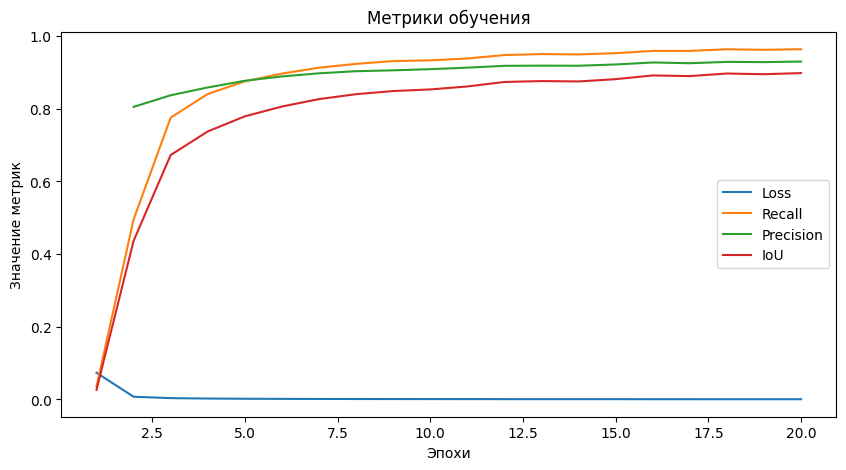

Test loss: 0.029560483992099762
Test recall: 0.9518071750424942, Test precision: 0.9200047850608826
False positive rate: 52.00535583496094
Test IoU: 0.8793877351958796


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

# Загрузка данных
data = np.load('images_r.npy')
labels = np.load('masks_r.npy')

# Разбиение данных на train и test
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Преобразование данных в тензоры
train_data = torch.Tensor(train_data).cuda()
train_labels = torch.Tensor(train_labels).cuda()
test_data = torch.Tensor(test_data).cuda()
test_labels = torch.Tensor(test_labels).cuda()

import torch
import torch.nn as nn

class ImprovedEncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(512, 512, 3, padding=1),  # добавленный слой
            nn.BatchNorm2d(512),  # добавленный слой
            nn.LeakyReLU(negative_slope=0.2)  # добавленный слой
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(32, 16, 3, padding=1),  # добавленный слой
            nn.BatchNorm2d(16),  # добавленный слой
            nn.LeakyReLU(negative_slope=0.2),  # добавленный слой
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Энкодер
        x = self.encoder(x)

        # Декодер
        x = self.decoder(x)

        return x



# Создание экземпляра модели и определение функции потерь и оптимизатора
model = ImprovedEncoderDecoder().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

import matplotlib.pyplot as plt

# Создание списков для хранения значений метрик
train_loss_values = []
train_recall_values = []
train_precision_values = []
train_iou_values = []

# Обучение модели
batch_size = 16
epochs = 20
num_batches = len(train_data) // batch_size
for epoch in range(epochs):
    running_loss = 0.0
    running_recall = 0.0
    running_precision = 0.0
    running_iou = 0.0

    for i in range(num_batches):
        # Обнуление градиентов перед каждой итерацией обучения
        optimizer.zero_grad()

        # Прямой проход
        batch_data = train_data[i*batch_size:(i+1)*batch_size]
        batch_labels = train_labels[i*batch_size:(i+1)*batch_size]
        outputs = model(batch_data.unsqueeze(1))
        loss = criterion(outputs, batch_labels.unsqueeze(1))
        running_loss += loss.item()

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Расчет метрик recall и precision
        with torch.no_grad():
            predicted = (outputs > 0.5).float()
            true_positives = (predicted * batch_labels.unsqueeze(1)).sum()
            false_positives = (predicted * (1 - batch_labels.unsqueeze(1))).sum()
            false_negatives = ((1 - predicted) * batch_labels.unsqueeze(1)).sum()
            recall = true_positives / (true_positives + false_negatives)
            precision = true_positives / (true_positives + false_positives)
            running_recall += recall.item()
            running_precision += precision.item()

            # Расчет метрики IoU
            intersection = (predicted * batch_labels.unsqueeze(1)).sum()
            union = (predicted + batch_labels.unsqueeze(1)).sum() - intersection
            iou = intersection / union
            running_iou += iou.item()

    # Вывод loss, recall, precision и IoU на каждой эпохе
    avg_loss = running_loss / num_batches
    avg_recall = running_recall / num_batches
    avg_precision = running_precision / num_batches
    avg_iou = running_iou / num_batches
    print(f"Epoch {epoch+1} loss: {avg_loss}, recall: {avg_recall}, precision: {avg_precision}, IoU: {avg_iou}")

    # Добавление значений метрик в списки
    train_loss_values.append(avg_loss)
    train_recall_values.append(avg_recall)
    train_precision_values.append(avg_precision)
    train_iou_values.append(avg_iou)

# Построение графика изменения метрик во время обучения
plt.figure(figsize=(10, 5))
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss_values, label='Loss')
plt.plot(epochs_range, train_recall_values, label='Recall')
plt.plot(epochs_range, train_precision_values, label='Precision')
plt.plot(epochs_range, train_iou_values, label='IoU')

plt.xlabel('Эпохи')
plt.ylabel('Значение метрик')
plt.title('Метрики обучения')
plt.legend()
plt.show()

# Тестирование модели
with torch.no_grad():
    model.eval()
    test_outputs = (model(test_data.unsqueeze(1)) > 0.5).float()
    test_loss = criterion(test_outputs, test_labels.unsqueeze(1))
    print(f"Test loss: {test_loss.item()}")
    batch_size = 16
    num_batches = len(test_data) // batch_size

    running_recall = 0.0
    running_precision = 0.0
    running_iou = 0.0  # Добавленная метрика IoU
    false_positive_pixels = 0
    false_positive_total_pixels = 0

    for i in range(num_batches):
        batch_data = test_data[i * batch_size:(i + 1) * batch_size]
        batch_labels = test_labels[i * batch_size:(i + 1) * batch_size]
        outputs = model(batch_data.unsqueeze(1))
        predicted = (outputs > 0.5).float()
        true_positives = (predicted * batch_labels.unsqueeze(1)).sum()
        false_positives = (predicted * (1 - batch_labels.unsqueeze(1))).sum()
        false_negatives = ((1 - predicted) * batch_labels.unsqueeze(1)).sum()
        recall = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        running_recall += recall.item()
        running_precision += precision.item()
        false_positive_pixels += ((batch_data == 1) & (predicted == 0)).sum()
        false_positive_total_pixels += ((batch_data == 1) & (batch_labels == 0)).sum()

        # Расчет метрики IoU
        intersection = (predicted * batch_labels.unsqueeze(1)).sum()
        union = (predicted + batch_labels.unsqueeze(1)).sum() - intersection
        iou = intersection / union
        running_iou += iou.item()

    avg_recall = running_recall / num_batches
    avg_precision = running_precision / num_batches
    avg_iou = running_iou / num_batches

    print(f"Test recall: {avg_recall}, Test precision: {avg_precision}")
    false_positive_rate = false_positive_pixels / false_positive_total_pixels
    print(f"False positive rate: {false_positive_rate}")
    print(f"Test IoU: {avg_iou}")

import matplotlib.pyplot as plt

total_true_removed_signals = 0
total_predicted_removed_signals = 0
total_true_signals = 0
total_input_true_removed_signals = 0

for i in range(len(test_data)):
    plt.matshow(test_data[i].cpu(), aspect='auto')
    plt.title("Input")
    plt.show()

    plt.matshow(test_labels[i].cpu(), aspect='auto')
    plt.title("True Mask")
    plt.show()

    plt.matshow((test_outputs[i, 0] > 0.5).float().cpu(), aspect='auto')
    plt.title("Predicted Mask")
    plt.show()

    input_signal = test_data[i].cpu().numpy()
    true_mask = test_labels[i].cpu().numpy()
    predicted_mask = (test_outputs[i, 0] > 0.5).float().cpu().numpy()

#     # Calculate the number of signals on each line
#     print(f"Number of signals on each line:")
#     for j in range(input_signal.shape[0]):
#         line_input_signals = 0
#         line_true_removed_signals = 0
#         line_predicted_removed_signals = 0

#         # Track the start of a continuous sequence of 1s
#         start = -1
#         for k in range(input_signal.shape[1]):
#             if input_signal[j, k] == 1:
#                 if start == -1:
#                     start = k
#             else:
#                 if start != -1:
#                     line_input_signals += 1
#                     if np.all(true_mask[j, start:k] == 0):
#                         line_true_removed_signals += 1
#                         if np.all(predicted_mask[j, start:k] == 0):
#                             line_predicted_removed_signals += 1
#                     start = -1

#         # Check if there is an ongoing sequence at the end
#         if start != -1:
#             line_input_signals += 1
#             if np.all(true_mask[j, start:] == 0):
#                 line_true_removed_signals += 1
#                 if np.all(predicted_mask[j, start:] == 0):
#                     line_predicted_removed_signals += 1

#         print(f"Line {j+1}: Input Signals: {line_input_signals}, True Removed Signals: {line_true_removed_signals}, Predicted Removed Signals: {line_predicted_removed_signals}")

#         # Accumulate the total number of True Removed Signals and Predicted Removed Signals
#         total_true_removed_signals += line_true_removed_signals
#         total_predicted_removed_signals += line_predicted_removed_signals

#         # Accumulate the total number of True Signals where input=1, true=1, and predicted=0
#         total_input_true_removed_signals += np.sum((input_signal[j, :] == 1) & (true_mask[j, :] == 1) & (predicted_mask[j, :] == 0))

#     # Calculate the total number of True Signals
#     total_true_signals += np.sum(true_mask == 1)

#     print()

# # Calculate the percentage of Predicted Removed Signals over True Removed Signals
# percent_removed_predicted_true = (total_predicted_removed_signals / total_true_removed_signals) * 100
# percent_removed_input_true = (total_input_true_removed_signals / total_true_signals) * 100

# print(f"Total True Removed Signals: {total_true_removed_signals}")
# print(f"Total Predicted Removed Signals: {total_predicted_removed_signals}")
# print(f"Percentage of Predicted Removed Signals / True Removed Signals: {percent_removed_predicted_true}%")
# print(f"Percentage of Input True Signals Removed / True Signals: {percent_removed_input_true}%")